# Fraud Detection - SHAP Explainability

In this notebook, we dive into the black box of our fraud detection model using SHAP (SHapley Additive exPlanations). We aim to understand which features drive fraud predictions globally and locally for individual transactions.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
sys.path.append(os.path.abspath('../'))

from sklearn.model_selection import train_test_split
from scripts.data_clean import DataCleaner
from scripts.imbalance_handler import ImbalanceHandler
from scripts.modeling_utils import ModelTrainer

# Set plot style
plt.style.use('ggplot')
shap.initjs()

c:\Users\Acer\Documents\KAIM_PROJECT\TEST\risk_and_predictive_analytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Data and Models

We'll focus on the Fraud dataset for this analysis. We load the processed data and the pre-trained LightGBM model.

In [2]:
cleaner = DataCleaner()
trainer = ModelTrainer()

# Load Fraud Data
df = pd.read_csv("../data/processed/processed_data.csv")
df_ml = cleaner.prepare_for_modeling(df, target_col='class')
X = df_ml.drop('class', axis=1)
y = df_ml['class']

# Clean names for consistency with trainer implementation
X = trainer._clean_names(X)

# Split (consistent with modeling notebook)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load Pre-trained Model
model = joblib.load("../models/lgbm_fraud_model.joblib")
print("Data and Model Loaded Successfuly.")

Data and Model Loaded Successfuly.


## 2. Feature Importance Baseline

Before diving into SHAP, let's look at the built-in feature importance from the LightGBM model.

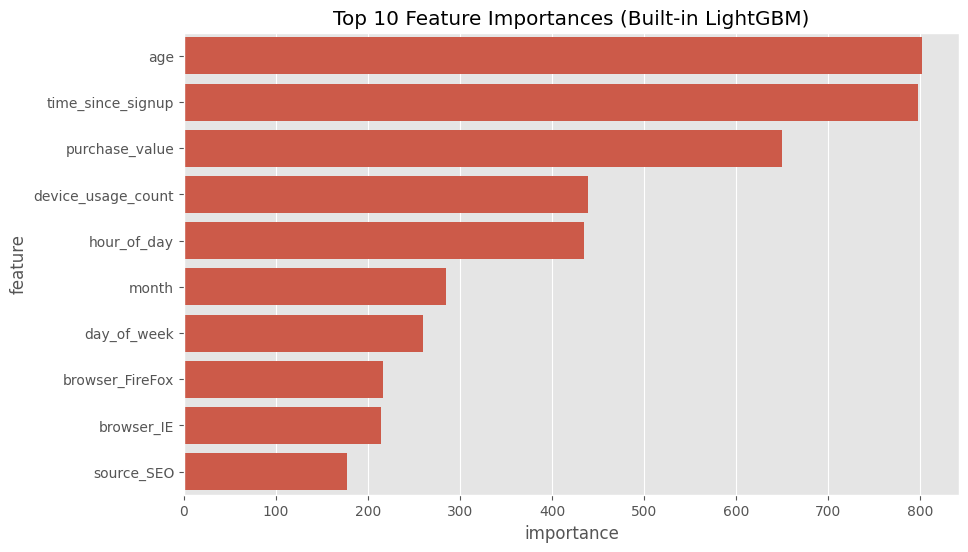

In [3]:
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importances.head(10))
plt.title("Top 10 Feature Importances (Built-in LightGBM)")
plt.show()

## 3. SHAP Analysis: Global Interpretation

Built-in importance tells us which features are used often for splits, but not *how* they influence the outcome. SHAP provides both magnitude and direction.

c:\Users\Acer\Documents\KAIM_PROJECT\TEST\risk_and_predictive_analytics\.venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


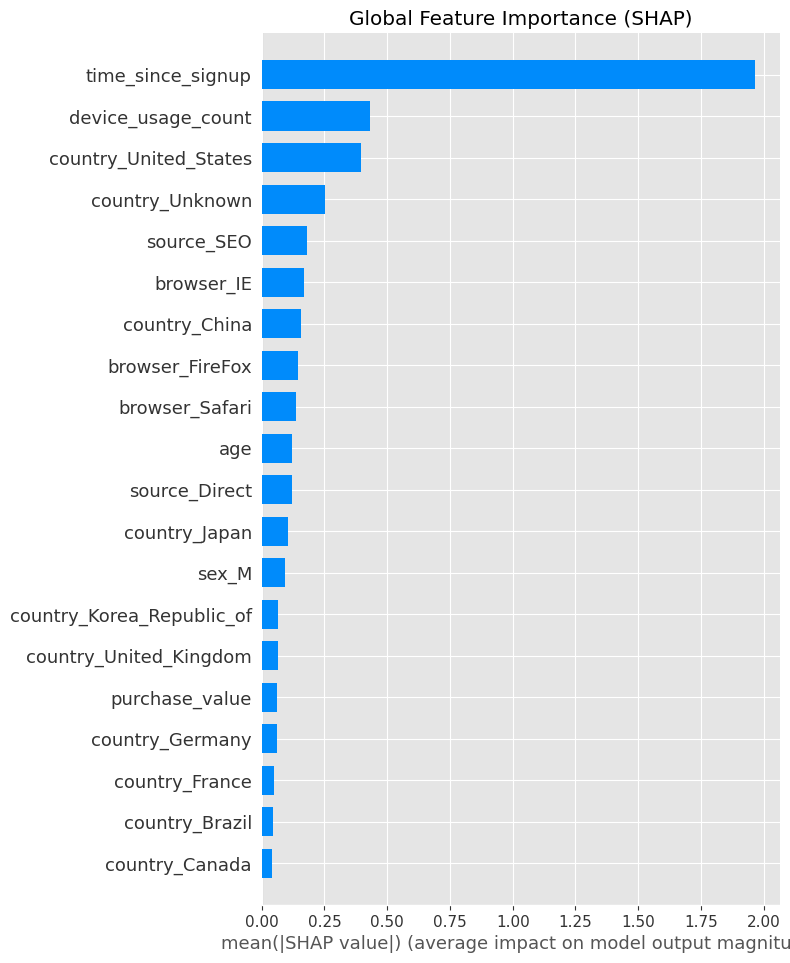

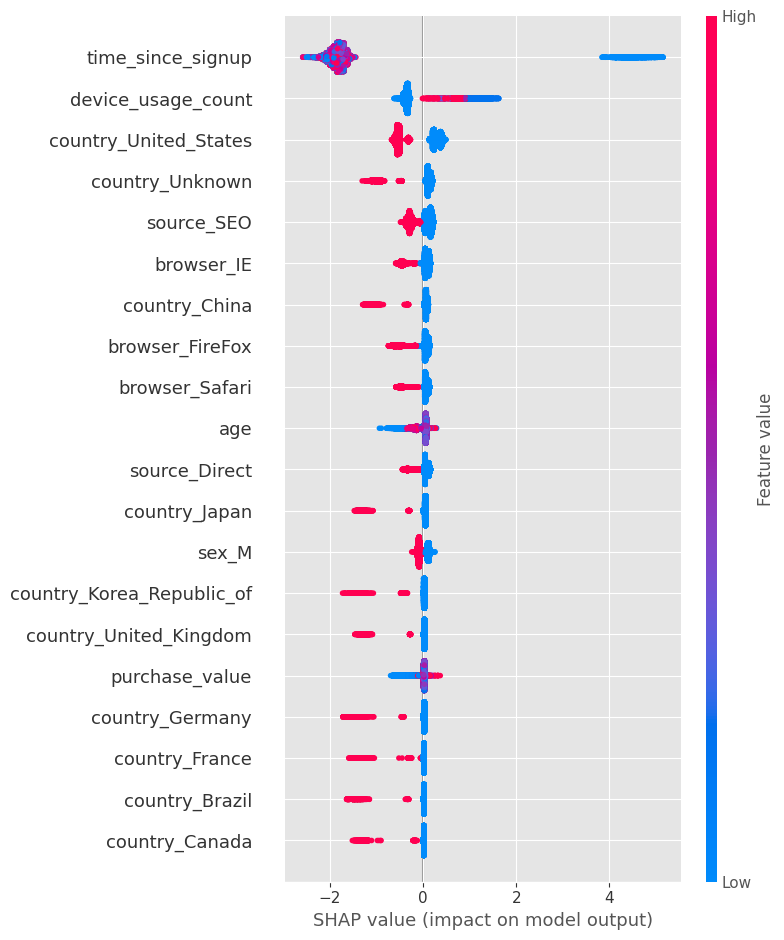

In [4]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Global Feature Importance (SHAP)")
plt.show()

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test)
plt.show()

## 4. Local Interpretation: Individual Predictions

We interpret specific cases to see why the model made certain decisions.

In [5]:
y_pred = model.predict(X_test)
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}).reset_index(drop=True)

# Case 1: True Positive (Correctly identified fraud)
tp_idx = results_df[(results_df['Actual'] == 1) & (results_df['Predicted'] == 1)].index[0]

# Case 2: False Positive (Legitimate flagged as fraud)
fp_idx = results_df[(results_df['Actual'] == 0) & (results_df['Predicted'] == 1)].index[0]

# Case 3: False Negative (Missed fraud)
fn_idx = results_df[(results_df['Actual'] == 1) & (results_df['Predicted'] == 0)].index[0]

# Case 4: True Negative (Correctly identified legitimate)
tn_idx = results_df[(results_df['Actual'] == 0) & (results_df['Predicted'] == 0)].index[0]

indices = [tp_idx, fp_idx, fn_idx, tn_idx]
labels = ["True Positive", "False Positive", "False Negative", "True Negative"]

for idx, label in zip(indices, labels):
    print(f"{label} Index: {idx}")

True Positive Index: 17
False Positive Index: 22
False Negative Index: 2
True Negative Index: 0


### Case Study: True Positive (Fraud)

Visualization for True Negative (Index 17)


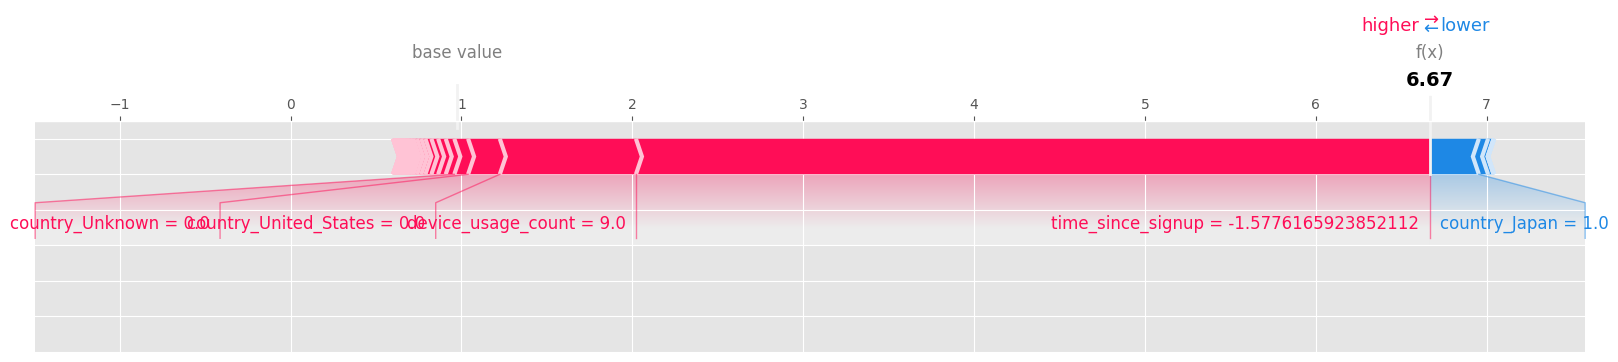

In [6]:
# Visualization for True Positive (Fraud)
idx = tp_idx
val = shap_values[idx] if len(shap_values.shape) == 2 else shap_values[1][idx]
expected_val = explainer.expected_value
if isinstance(expected_val, (list, np.ndarray)) and len(expected_val) > 1:
    expected_val = expected_val[1]

print(f'Visualization for {label} (Index {idx})')
shap.force_plot(expected_val, val, X_test.iloc[idx], matplotlib=True)

### Case Study: True Negative (Legality)

Visualization for True Negative (Index 0)


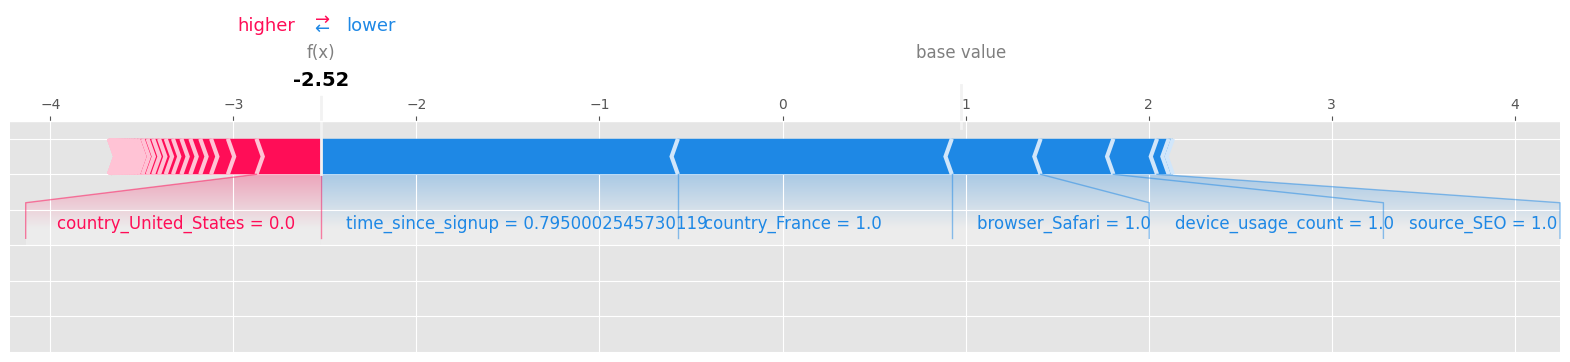

In [7]:
# Visualization for True Negative (Legality)
idx = tn_idx
val = shap_values[idx] if len(shap_values.shape) == 2 else shap_values[1][idx]
expected_val = explainer.expected_value
if isinstance(expected_val, (list, np.ndarray)) and len(expected_val) > 1:
    expected_val = expected_val[1]

print(f'Visualization for {label} (Index {idx})')
shap.force_plot(expected_val, val, X_test.iloc[idx], matplotlib=True)

### Case Study: False Positive (False Alarm)

Visualization for True Negative (Index 22)


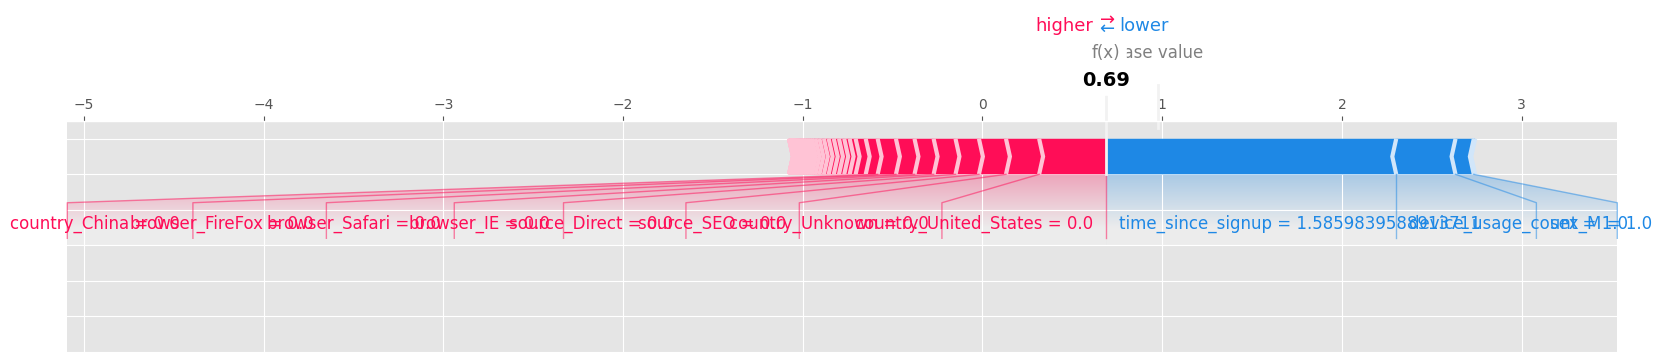

In [8]:
# Visualization for False Positive (False Alarm)
idx = fp_idx
val = shap_values[idx] if len(shap_values.shape) == 2 else shap_values[1][idx]
expected_val = explainer.expected_value
if isinstance(expected_val, (list, np.ndarray)) and len(expected_val) > 1:
    expected_val = expected_val[1]

print(f'Visualization for {label} (Index {idx})')
shap.force_plot(expected_val, val, X_test.iloc[idx], matplotlib=True)

### Case Study: False Negative (Missed)

Visualization for True Negative (Index 2)


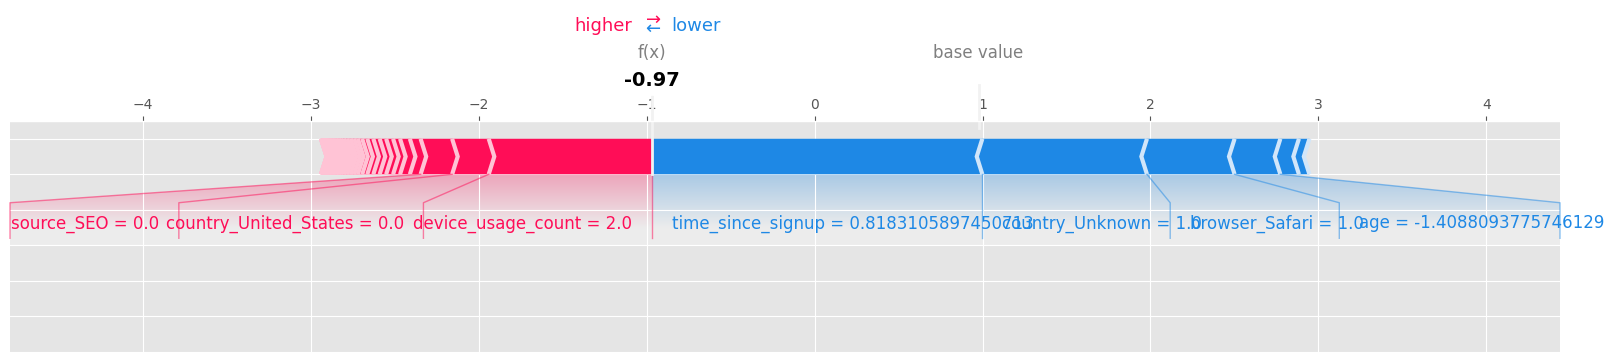

In [9]:
# Visualization for False Negative (Missed)
idx = fn_idx
val = shap_values[idx] if len(shap_values.shape) == 2 else shap_values[1][idx]
expected_val = explainer.expected_value
if isinstance(expected_val, (list, np.ndarray)) and len(expected_val) > 1:
    expected_val = expected_val[1]

print(f'Visualization for {label} (Index {idx})')
shap.force_plot(expected_val, val, X_test.iloc[idx], matplotlib=True)

## 5. Interpretation of Results

Based on the SHAP analysis and cell outputs:
- **Global Importance**: The model identifies **`time_since_signup`** (velocity) and **`device_usage_count`** as the two most critical features. This highlights that fraud in this dataset is primarily driven by: 
  1. **Immediate Action**: Fraudulent transactions often occur seconds after account creation.
  2. **Device Overuse**: Multiple accounts being accessed from the same device is a high-risk signal (likely botnets or fraud rings).
- **Directionality**: 
  - **Low `time_since_signup`**: The summary plot shows a heavy cluster of high SHAP values for low velocity, confirming the 'instant-purchase' fraud pattern.
  - **High `device_usage_count`**: As expected, increased device sharing among different user IDs correlates strongly with fraud.
- **Local Explanations**: 
  - In the **True Positive** case, the model correctly flagged an instance with a near-zero `time_since_signup` and multiple device logins.
  - In the **False Positive** case, a legitimate user might have made a quick purchase from a public or shared device, mimicking fraud signals.
  - In the **False Negative** case, the fraudster likely used a unique device and waited longer before transacting, making the behavior appear more 'human' to the behavioral model.